# Classification

## Team Name
>### Sigma  

## Team Member
>### 조현윤, 이상협, 정하연  

## Objective
> ### in search of better methods of using this behavioral data to predict which individuals they should approach—and even when and how to approach them.
> ### to create a classification algorithm that accurately identifies which customers have the most potential business value for Red Hat based on their characteristics and activities.
> ### to predict the potential business value of a person who has performed a specific activity.

## Evaluation
> ### valuated on area under the ROC curve between the predicted and the observed outcome.

## Submission File
> ### For each activity_id in the test set, you must predict a probability for the 'outcome' variable, represented by a number between 0 and 1.
~~~~
activity_id,outcome
act1_1,0
act1_100006,0
act1_100050,0
~~~~

## Data
> ### uses two separate data files that may be joined together to create a single, unified data table: a people file and an activity file.
> ### The people file contains all of the unique people (and the corresponding characteristics) that have performed activities over time. Each row in the people file represents a unique person. Each person has a unique people_id.
> ### The activity file contains all of the unique activities (and the corresponding activity characteristics) that each person has performed over time. Each row in the activity file represents a unique activity performed by a person on a certain date. Each activity has a unique activity_id.
> ### The activity file contains several different categories of activities. 
>> Type 1 activities are different from type 2-7 activities because there are more known characteristics associated with type 1 activities (nine in total) than type 2-7 activities (which have only one associated characteristic).
> ### To develop a predictive model with this data, you will likely need to join the files together into a single data set. The two files can be joined together using person_id as the common key. All variables are categorical, with the exception of 'char_38' in the people file, which is a continuous numerical variable.

## Reference 
[kaggel Predicting Red Hat Business Value](https://www.kaggle.com/c/predicting-red-hat-business-value)

### Load Python Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from datetime import date
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.stattools as stools
import scipy as sp
%matplotlib inline

In [2]:
import xgboost

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [4]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
from sklearn.metrics import *

In [6]:
from sklearn.ensemble import VotingClassifier

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

In [8]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier


In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
cv =KFold(10)

## Exploratory Data Analysis (EDA )¶

## Load Data Set

In [15]:
# activity data set
act_Train = pd.read_csv('./data/act_train.csv')
act_Test = pd.read_csv('./data/act_test.csv')
# people data set
people = pd.read_csv('./data/people.csv')

### Split people data set wether train data set or test data set

In [16]:
idx_train =list(act_Train['people_id'].value_counts().index)
idx_test =list(act_Test['people_id'].value_counts().index)

In [17]:
train_people = people.loc[people['people_id'].isin(idx_train)]
test_people = people.loc[people['people_id'].isin(idx_test)]

In [18]:
train_people.to_csv('./data/act_train_people.csv',index=False)
test_people.to_csv('./data/act_test_people.csv',index=False)

In [19]:
print('Number of active people: {}'.format(act_Train['people_id'].nunique()))

Number of active people: 151295


In [20]:
print('Number of active people: {}'.format(act_Test['people_id'].nunique()))

Number of active people: 37823


In [21]:
trainMerge = pd.merge(act_Train,people, on='people_id')
trainMerge.tail()

,people_id,activity_id,date_x,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
2197286,ppl_99994,act2_4668076,2023-06-16,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,False,True,True,True,True,95
2197287,ppl_99994,act2_4743548,2023-03-30,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,False,True,True,True,True,95
2197288,ppl_99994,act2_536973,2023-01-19,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,False,True,True,True,True,95
2197289,ppl_99994,act2_688656,2023-05-02,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,False,True,True,True,True,95
2197290,ppl_99994,act2_715089,2023-06-15,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,False,True,True,True,True,95


In [22]:
trainMerge.to_csv('./data/train_merge.csv',index=False)

In [23]:
testMerge = pd.merge(act_Test,people, on='people_id')
testMerge.tail()

,people_id,activity_id,date_x,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
498682,ppl_99997,act2_4367092,2023-04-22,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,36
498683,ppl_99997,act2_4404220,2022-11-12,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,36
498684,ppl_99997,act2_448830,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,36
498685,ppl_99997,act2_450133,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,36
498686,ppl_99997,act2_847967,2022-10-15,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,36


In [24]:
testMerge.to_csv('./data/test_merge.csv',index=False)

In [25]:
dfx = act_Train.groupby(['people_id','outcome']).size().unstack()
dfx = dfx.fillna(0).astype(int)

In [26]:
only1 = dfx[(dfx[0]==0) & (dfx[1]!=0)]
only0 = dfx[(dfx[0]!=0) & (dfx[1]==0)]
mix_0or1 = dfx[(dfx[0]!=0) & (dfx[1]!=0)]

In [27]:
print (len(only1.index),len(only0.index),len(mix_0or1))

62115 82524 6656


In [28]:
train_People = pd.merge(train_people, dfx, left_on = 'people_id',right_index = True)

In [29]:
train_People.rename(columns={0:'outcome_0',1:'outcome_1'}, inplace = True)

In [30]:
def ax(x):
    if x['outcome_0'] !=0 and x['outcome_1'] ==0:
        return 0
    elif x['outcome_0'] ==0 and x['outcome_1'] !=0:
        return 1
    else:
        return 2

In [31]:
train_People.head()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,outcome_0,outcome_1
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,True,False,False,True,True,True,False,36,6,0
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,True,True,True,True,True,True,False,76,0,2
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,...,True,True,True,True,False,True,True,99,0,34
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,...,True,False,False,False,True,True,False,84,0,3
7,ppl_100013,type 2,group 4204,type 3,2023-01-24,type 4,type 8,type 4,type 1,type 7,...,True,True,True,True,False,True,True,91,0,5


In [32]:
train_People['result'] = train_People.apply(ax, axis = 1)

In [33]:
train_People.tail()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_32,char_33,char_34,char_35,char_36,char_37,char_38,outcome_0,outcome_1,result
189111,ppl_99981,type 2,group 17304,type 2,2023-01-26,type 5,type 5,type 5,type 2,type 5,...,True,False,True,False,True,True,3,7,0,0
189113,ppl_99987,type 1,group 8600,type 1,2022-04-02,type 4,type 6,type 4,type 3,type 11,...,True,False,True,False,True,True,89,0,1,1
189114,ppl_9999,type 2,group 17304,type 2,2023-02-23,type 6,type 2,type 8,type 3,type 11,...,False,False,False,False,False,False,0,2,0,0
189115,ppl_99992,type 2,group 17304,type 2,2020-06-25,type 5,type 5,type 3,type 4,type 16,...,False,False,False,False,False,False,0,2,0,0
189116,ppl_99994,type 2,group 17764,type 3,2023-01-06,type 2,type 7,type 2,type 1,type 2,...,True,False,True,True,True,True,95,0,46,1


In [34]:
train_People.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151295 entries, 0 to 189116
Data columns (total 44 columns):
people_id    151295 non-null object
char_1       151295 non-null object
group_1      151295 non-null object
char_2       151295 non-null object
date         151295 non-null object
char_3       151295 non-null object
char_4       151295 non-null object
char_5       151295 non-null object
char_6       151295 non-null object
char_7       151295 non-null object
char_8       151295 non-null object
char_9       151295 non-null object
char_10      151295 non-null bool
char_11      151295 non-null bool
char_12      151295 non-null bool
char_13      151295 non-null bool
char_14      151295 non-null bool
char_15      151295 non-null bool
char_16      151295 non-null bool
char_17      151295 non-null bool
char_18      151295 non-null bool
char_19      151295 non-null bool
char_20      151295 non-null bool
char_21      151295 non-null bool
char_22      151295 non-null bool
char_23      15

In [35]:
for idx in trainMerge.columns:
    if 'type 0' in list(trainMerge[idx].unique()):
        print (idx, 'type 0')
    else:pass

In [36]:
trainMerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2197291 entries, 0 to 2197290
Data columns (total 55 columns):
people_id            object
activity_id          object
date_x               object
activity_category    object
char_1_x             object
char_2_x             object
char_3_x             object
char_4_x             object
char_5_x             object
char_6_x             object
char_7_x             object
char_8_x             object
char_9_x             object
char_10_x            object
outcome              int64
char_1_y             object
group_1              object
char_2_y             object
date_y               object
char_3_y             object
char_4_y             object
char_5_y             object
char_6_y             object
char_7_y             object
char_8_y             object
char_9_y             object
char_10_y            bool
char_11              bool
char_12              bool
char_13              bool
char_14              bool
char_15              bool
char

In [37]:
trainMerge.head()

,people_id,activity_id,date_x,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36


In [38]:
for idx in trainMerge.columns:
    print (idx)
    if idx not in ['people_id', 'activity_id', 'date_x','date_y', 'char_38', 'outcome']:
        if trainMerge[idx].dtype == 'object':
            trainMerge.fillna('type 0', inplace = True)
            trainMerge[idx] = trainMerge[idx].apply(lambda x:x.split(' ')[1]).astype(np.int32)
        elif trainMerge[idx].dtype == 'bool':
            trainMerge[idx] = trainMerge[idx].astype(np.int8)

people_id
activity_id
date_x
activity_category
char_1_x
char_2_x
char_3_x
char_4_x
char_5_x
char_6_x
char_7_x
char_8_x
char_9_x
char_10_x
outcome
char_1_y
group_1
char_2_y
date_y
char_3_y
char_4_y
char_5_y
char_6_y
char_7_y
char_8_y
char_9_y
char_10_y
char_11
char_12
char_13
char_14
char_15
char_16
char_17
char_18
char_19
char_20
char_21
char_22
char_23
char_24
char_25
char_26
char_27
char_28
char_29
char_30
char_31
char_32
char_33
char_34
char_35
char_36
char_37
char_38


In [39]:
trainMerge['date_x'] = pd.to_datetime(trainMerge['date_x'])
trainMerge['date_y'] = pd.to_datetime(trainMerge['date_y'])

In [40]:
trainMerge['year_x'] = trainMerge['date_x'].dt.year
trainMerge['month_x'] = trainMerge['date_x'].dt.month
trainMerge['day_x'] = trainMerge['date_x'].dt.day
trainMerge['weekday_x'] = trainMerge['date_x'].dt.weekday
trainMerge['weekend_x'] = ((trainMerge.weekday_x == 0) | (trainMerge.weekday_x == 6)).astype(int)
trainMerge = trainMerge.drop('date_x', axis = 1)
    
trainMerge['year_y'] = trainMerge['date_y'].dt.year
trainMerge['month_y'] = trainMerge['date_y'].dt.month
trainMerge['day_y'] = trainMerge['date_y'].dt.day
trainMerge['weekday_y'] = trainMerge['date_y'].dt.weekday
trainMerge['weekend_y'] = ((trainMerge.weekday_y == 0) | (trainMerge.weekday_y == 6)).astype(int)
trainMerge = trainMerge.drop('date_y', axis = 1)

In [41]:
trainMerge.tail()

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,year_x,month_x,day_x,weekday_x,weekend_x,year_y,month_y,day_y,weekday_y,weekend_y
2197286,ppl_99994,act2_4668076,4,0,0,0,0,0,0,0,...,2023,6,16,4,0,2023,1,6,4,0
2197287,ppl_99994,act2_4743548,4,0,0,0,0,0,0,0,...,2023,3,30,3,0,2023,1,6,4,0
2197288,ppl_99994,act2_536973,2,0,0,0,0,0,0,0,...,2023,1,19,3,0,2023,1,6,4,0
2197289,ppl_99994,act2_688656,4,0,0,0,0,0,0,0,...,2023,5,2,1,0,2023,1,6,4,0
2197290,ppl_99994,act2_715089,2,0,0,0,0,0,0,0,...,2023,6,15,3,0,2023,1,6,4,0


In [42]:
mergeX = trainMerge.drop(['people_id','activity_id','outcome'],axis = 1)
mergey = trainMerge['outcome']

In [43]:
for idx in testMerge.columns:
    print (idx)
    if idx not in ['people_id', 'activity_id', 'date_x','date_y', 'char_38', 'outcome']:
        if testMerge[idx].dtype == 'object':
            testMerge.fillna('type 0', inplace = True)
            testMerge[idx] = testMerge[idx].apply(lambda x:x.split(' ')[1]).astype(np.int32)
        elif testMerge[idx].dtype == 'bool':
            testMerge[idx] = testMerge[idx].astype(np.int8)

people_id
activity_id
date_x
activity_category
char_1_x
char_2_x
char_3_x
char_4_x
char_5_x
char_6_x
char_7_x
char_8_x
char_9_x
char_10_x
char_1_y
group_1
char_2_y
date_y
char_3_y
char_4_y
char_5_y
char_6_y
char_7_y
char_8_y
char_9_y
char_10_y
char_11
char_12
char_13
char_14
char_15
char_16
char_17
char_18
char_19
char_20
char_21
char_22
char_23
char_24
char_25
char_26
char_27
char_28
char_29
char_30
char_31
char_32
char_33
char_34
char_35
char_36
char_37
char_38


In [44]:
testMerge['date_x'] = pd.to_datetime(testMerge['date_x'])
testMerge['date_y'] = pd.to_datetime(testMerge['date_y'])

In [45]:
testMerge['year_x'] = testMerge['date_x'].dt.year
testMerge['month_x'] = testMerge['date_x'].dt.month
testMerge['day_x'] = testMerge['date_x'].dt.day
testMerge['weekday_x'] = testMerge['date_x'].dt.weekday
testMerge['weekend_x'] = ((testMerge.weekday_x == 0) | (testMerge.weekday_x == 6)).astype(int)
testMerge = testMerge.drop('date_x', axis = 1)
    
testMerge['year_y'] = testMerge['date_y'].dt.year
testMerge['month_y'] = testMerge['date_y'].dt.month
testMerge['day_y'] = testMerge['date_y'].dt.day
testMerge['weekday_y'] = testMerge['date_y'].dt.weekday
testMerge['weekend_y'] = ((testMerge.weekday_y == 0) | (testMerge.weekday_y == 6)).astype(int)
testMerge = testMerge.drop('date_y', axis = 1)

In [46]:
testX = testMerge.drop(['people_id','activity_id'],axis = 1)
#testy = trainMerge['outcome']

In [47]:
import time
import xgboost as xgb
from sklearn.cross_validation import train_test_split

In [105]:
def run(train, test, random_state=0):
    eta = 1.3
    max_depth = 3
    subsample = 0.8
    colsample_bytree = 0.8
    start_time = time.time()
    params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
        "seed": random_state
    }
    num_boost_round = 2
    early_stopping_rounds = 10
    test_size = 0.1
    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    y_train = X_train['outcome']
    y_valid = X_valid['outcome']
    X_train = X_train.drop(['people_id','activity_id','outcome'],axis = 1)
    X_valid = X_valid.drop(['people_id','activity_id','outcome'], axis = 1)
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    check = gbm.predict(xgb.DMatrix(X_valid), ntree_limit=gbm.best_iteration+1)
    score = roc_auc_score(y_valid, check)
    print (score)
    testActivityId = test['activity_id']
    test = test.drop(['people_id','activity_id'],axis = 1)
    test_prediction = gbm.predict(xgb.DMatrix(test), ntree_limit=gbm.best_iteration+1)
    out = pd.concat([testActivityId,pd.DataFrame(test_prediction.round())],axis = 1)
    out.rename({0:'outcome'},axis = 1,inplace = True)
    return out,test_prediction

In [106]:
x = run(trainMerge, testMerge)

[0]	train-auc:0.876135	eval-auc:0.875169
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.896448	eval-auc:0.895751
0.895751382685


In [48]:
X_train, X_valid = train_test_split(trainMerge, test_size=0.35, random_state=3)

In [49]:
from keras.utils import np_utils

#X_train.reset_index(inplace = True)
Y_train = np_utils.to_categorical(X_train['outcome'], 2)
X_train = X_train.drop(['people_id','activity_id','outcome'],axis = 1)

#X_valid.reset_index(inplace = True)
Y_valid = np_utils.to_categorical(X_valid['outcome'], 2)
X_valid = X_valid.drop(['people_id','activity_id','outcome'],axis = 1)

Using TensorFlow backend.


In [50]:
print (X_train.shape)
print (X_valid.shape)

(1428239, 60)
(769052, 60)


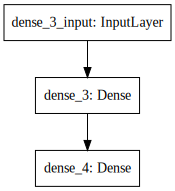

In [53]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

np.random.seed(0)

model = Sequential()
model.add(Dense(10000, input_dim=60, activation="sigmoid"))
model.add(Dense(2, activation="sigmoid"))
model.compile(optimizer=SGD(lr=5), loss='mean_squared_error', metrics=["accuracy"])

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [55]:
hist = model.fit(X_train.values, Y_train, 
                 epochs=300, batch_size=1500, 
                 validation_data=(X_valid.values, Y_valid), 
                 verbose=2)

Train on 1428239 samples, validate on 769052 samples
Epoch 1/300
478s - loss: 0.5000 - acc: 0.5562 - val_loss: 0.5000 - val_acc: 0.5558
Epoch 2/300
467s - loss: 0.5000 - acc: 0.5562 - val_loss: 0.5000 - val_acc: 0.5558
Epoch 3/300


KeyboardInterrupt: 